In [1]:
import os
import optuna
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
load_dotenv()

/Users/hanyuwu/Library/Caches/pypoetry/virtualenvs/stock-volatility-prediction-5RuW2YLE-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
# Global Variables
api_key = os.getenv('FMP_API_KEY')
ticker = 'NVDA'
start_date = '2018-01-01'
end_date = '2024-01-01'

In [3]:
url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?from={start_date}&to={end_date}&apikey={api_key}"
response = requests.get(url).json()

In [4]:
data = pd.DataFrame(response["historical"])
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date').reset_index(drop=True)
data["return"] = data["close"].pct_change()
data["return_squared"] = data["return"] ** 2
data["realized_vol"] = data["return"].rolling(window=5).std()
# data.reset_index(drop=True, inplace=True)
# data = data.iloc[1:].reset_index(drop=True)

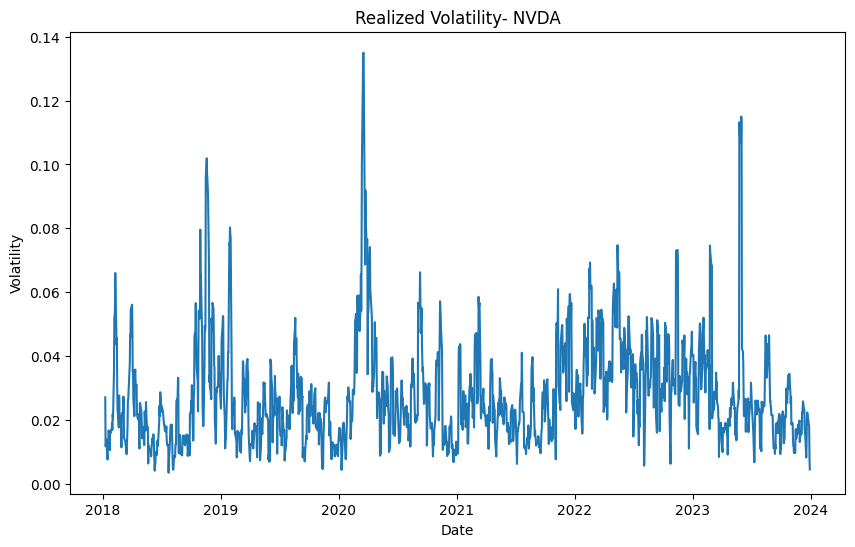

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(data["date"], data["realized_vol"])
plt.title('Realized Volatility- NVDA')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

In [6]:
ret = data["return"].iloc[1:]
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

In [14]:
ret

1       0.065811
2       0.005271
3       0.008427
4       0.030641
5      -0.000180
          ...   
1504   -0.003266
1505    0.009195
1506    0.002800
1507    0.002125
1508    0.000000
Name: return, Length: 1508, dtype: float64

In [12]:
returns_svm = ret ** 2

In [13]:
returns_svm

1       4.331034e-03
2       2.778433e-05
3       7.101376e-05
4       9.388506e-04
5       3.246490e-08
            ...     
1504    1.066658e-05
1505    8.455109e-05
1506    7.842137e-06
1507    4.514668e-06
1508    0.000000e+00
Name: return, Length: 1508, dtype: float64

In [18]:
returns_svm.reset_index(drop=True, inplace=True)

In [19]:
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)

In [20]:
X

,0,1
0,NaN,4.331034e-03
1,NaN,2.778433e-05
2,NaN,7.101376e-05
3,NaN,9.388506e-04
4,0.027157,3.246490e-08
...,...,...
1503,0.021960,1.066658e-05
1504,0.018554,8.455109e-05
1505,0.018309,7.842137e-06
1506,0.008242,4.514668e-06


In [21]:
X = X[4:].copy()
X = X.reset_index(drop=True)

In [22]:
X

,0,1
0,0.027157,3.246490e-08
1,0.011820,6.004923e-05
2,0.012290,3.197906e-06
3,0.013983,2.498215e-05
4,0.007689,1.622493e-04
...,...,...
1499,0.021960,1.066658e-05
1500,0.018554,8.455109e-05
1501,0.018309,7.842137e-06
1502,0.008242,4.514668e-06


In [24]:
realized_vol = realized_vol.dropna().reset_index(drop=True)

In [25]:
realized_vol

,return
0,0.027157
1,0.011820
2,0.012290
3,0.013983
4,0.007689
...,...
1499,0.021960
1500,0.018554
1501,0.018309
1502,0.008242


In [26]:
n = int(len(X) * 0.8)
print(n)
svr_rbf = SVR(kernel='rbf')

1203


In [34]:
def objective(trial):
    gamma = trial.suggest_loguniform('gamma', 1e-5, 1e2)
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    epsilon = trial.suggest_loguniform('epsilon', 1e-5, 1e2)
    
    svr_rbf = SVR(kernel='rbf', gamma=gamma, C=C, epsilon=epsilon)
    svr_rbf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
    predictions = svr_rbf.predict(X.iloc[n:])
    mse = mean_squared_error(realized_vol.iloc[n:], predictions)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2024-04-25 00:45:07,541] A new study created in memory with name: no-name-e16446d7-3131-4a3c-a1a9-f308e5c4fc1f
[I 2024-04-25 00:45:07,546] Trial 0 finished with value: 0.0008842123189937359 and parameters: {'gamma': 22.43446094925985, 'C': 8.31943882315612, 'epsilon': 0.08288383209541957}. Best is trial 0 with value: 0.0008842123189937359.
[I 2024-04-25 00:45:07,555] Trial 1 finished with value: 0.0003316642210747636 and parameters: {'gamma': 0.019111564994775197, 'C': 0.00016111459100591013, 'epsilon': 7.622032321486253e-05}. Best is trial 1 with value: 0.0003316642210747636.
[I 2024-04-25 00:45:07,557] Trial 2 finished with value: 0.0008842123189940382 and parameters: {'gamma': 6.066930464507957e-05, 'C': 0.5135711126287175, 'epsilon': 86.79136740412764}. Best is trial 1 with value: 0.0003316642210747636.
[I 2024-04-25 00:45:07,564] Trial 3 finished with value: 0.0002629726830103683 and parameters: {'gamma': 86.79451011422029, 'C': 0.0002547475559984276, 'epsilon': 0.0039838997968

In [35]:
print(f"Best Params: {best_params}")

Best Params: {'gamma': 4.7655690277432035, 'C': 27.18278624820095, 'epsilon': 7.32864412580772e-05}


In [36]:
svr_rbf = SVR(kernel='rbf', **best_params)

In [37]:
svr_rbf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))

SVR(C=27.18278624820095, epsilon=7.32864412580772e-05, gamma=4.7655690277432035)

In [38]:
predict_svr_rbf = svr_rbf.predict(X.iloc[n:])

In [39]:
test_set = pd.DataFrame({'Realized Volatility': realized_vol.iloc[n:].values.reshape(-1,), 'Predicted Volatility': predict_svr_rbf})

In [41]:
test_set

,Realized Volatility,Predicted Volatility
1203,0.045800,0.042289
1204,0.042866,0.039643
1205,0.021913,0.021324
1206,0.006345,0.008188
1207,0.018589,0.020064
...,...,...
1499,0.021960,0.021038
1500,0.018554,0.018198
1501,0.018309,0.017938
1502,0.008242,0.009631


Text(0, 0.5, 'Volatility')

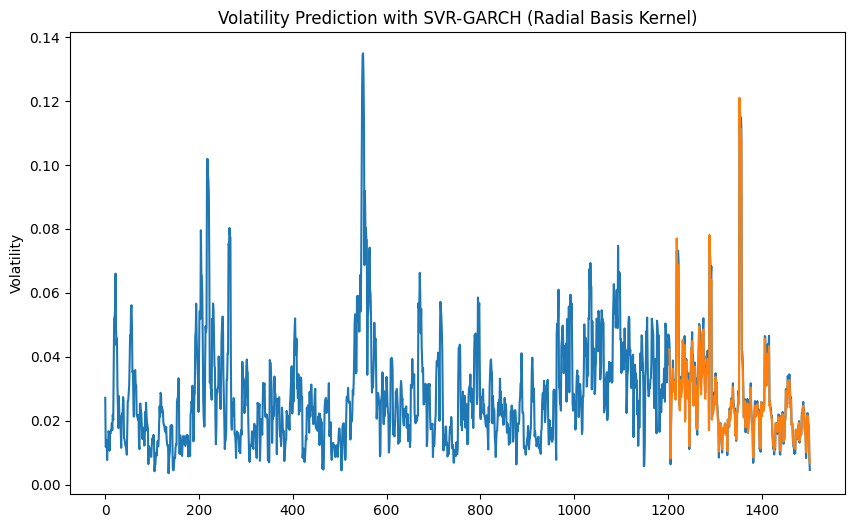

In [40]:
test_set.index = realized_vol.index[n:]
plt.figure(figsize=(10, 6))
plt.plot(realized_vol, label='Realized Volatility')
plt.plot(test_set['Predicted Volatility'], label='Predicted Volatility')
plt.title('Volatility Prediction with SVR-GARCH (Radial Basis Kernel)', fontsize=12)
plt.ylabel('Volatility')

In [43]:
data_list = []

for page in tqdm(range(300)):
    url = f'https://financialmodelingprep.com/api/v3/stock_news?tickers={ticker}&page={page}&apikey={api_key}'

    response = requests.get(url).json()

    for item in response:
        data_list.append({'text': item['text'], 'publishedDate': item['publishedDate']})

news_data = pd.DataFrame(data_list)

news_data.head()

100%|██████████| 300/300 [06:36<00:00,  1.32s/it]


,text,publishedDate
0,"Here, we discuss four AI stocks, Arista Networ...",2024-04-24 10:26:08
1,"Nvidia is acquiring Run:ai, a startup that mak...",2024-04-24 10:02:19
2,"Here, we have picked four semiconductor stocks...",2024-04-24 09:41:17
3,NVIDIA Corp (NASDAQ:NVDA) stock has more than ...,2024-04-24 08:00:12
4,A financial advisor can help you understand th...,2024-04-24 07:30:00


In [45]:
news_data.to_csv('news_data.csv', index=False)

In [ ]:
pd.to_datetime(news_data['publishedDate']).dt.date

In [ ]:
data_list = []

for page in tqdm(range(200)):
    url = f'https://financialmodelingprep.com/api/v4/historical/social-sentiment?symbol={ticker}&page={page}&apikey={api_key}'

    response = requests.get(url).json()

    for item in response:
        data_list.append({  "date": item["date"],
        "symbol": item["symbol"],
        "stocktwitsPosts": item["stocktwitsPosts"],
        "twitterPosts": item["twitterPosts"],
        "stocktwitsComments": item["stocktwitsComments"],
        "twitterComments": item["twitterComments"],
        "stocktwitsLikes": item["stocktwitsLikes"],
        "twitterLikes": item["twitterLikes"],
        "stocktwitsImpressions": item["stocktwitsImpressions"],
        "twitterImpressions": item["twitterImpressions"],
        "stocktwitsSentiment": item["stocktwitsSentiment"],
        "twitterSentiment": item["twitterSentiment"],
        })

twitter_data = pd.DataFrame(data_list)

twitter_data.head()

In [ ]:
len(pd.to_datetime(twitter_data['date']).dt.date.unique())